<a href="https://colab.research.google.com/github/babaroscopy/colab/blob/main/Recognizing_AI_vs_Original_interior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
from google.colab import files
import zipfile
import os

# Upload the zip file
uploaded = files.upload()

# Extract the zip file into a specific directory
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        # Unzip the file to a desired folder in Colab (e.g., '/content/images')
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('/content/images')  # You can change the path if needed

# List the contents of the extracted directory to verify everything was unzipped
os.listdir('/content/images')


Saving OR_Interior.zip to OR_Interior.zip
Saving AI_Interior.zip to AI_Interior.zip


['AI_Interior', 'OR_Interior']

Found 116 images belonging to 2 classes.
Found 29 images belonging to 2 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4788 - loss: 0.8392 - val_accuracy: 0.7241 - val_loss: 0.5994
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.6239 - loss: 0.6468 - val_accuracy: 0.6897 - val_loss: 0.6351
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.7598 - loss: 0.6543 - val_accuracy: 0.7241 - val_loss: 0.5480
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.7531 - loss: 0.5171 - val_accuracy: 0.7241 - val_loss: 0.5100
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.7143 - loss: 0.5477 - val_accuracy: 0.7586 - val_loss: 0.4656
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.7545 - loss: 0.4961 - val_accuracy: 0.8621 - val_loss: 0.4841
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.7490 - loss: 0.5077 - val_accuracy: 0.8621 - val_loss: 0.4453
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7617 - loss: 0.5293 - val_accuracy: 0.7931 - val_loss: 0.4481
Epoch 9/20


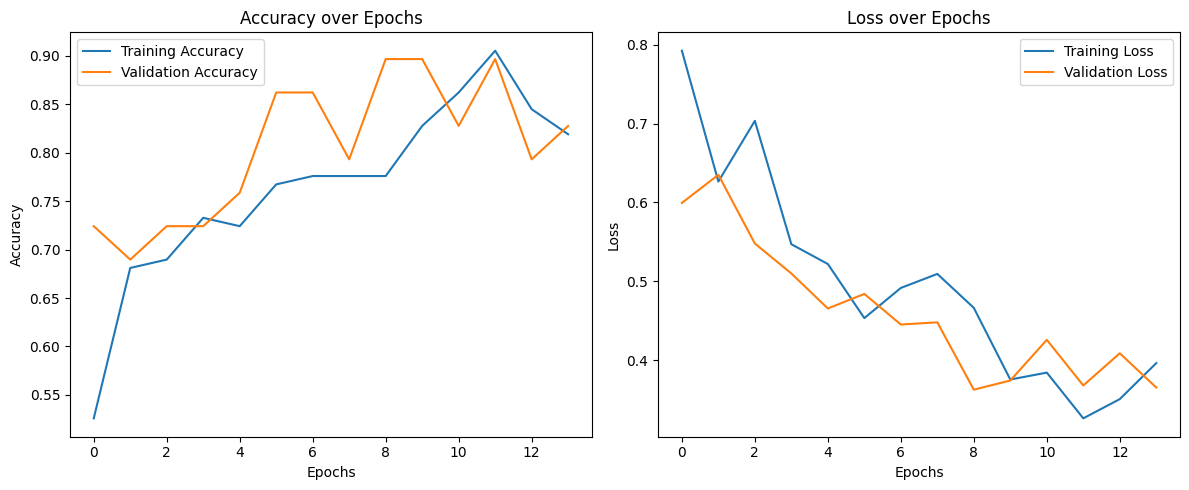

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


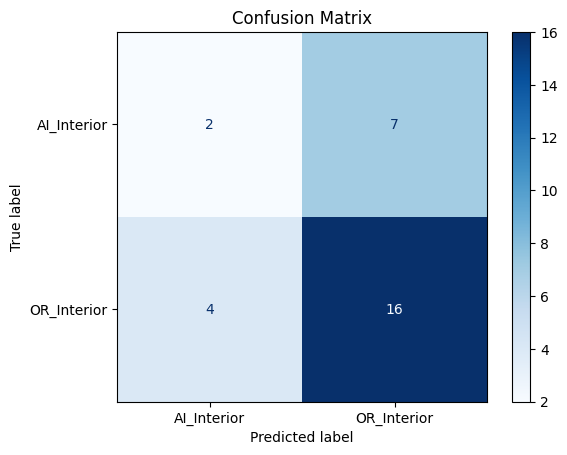

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Base directory with AI and Original folders
base_dir = '/content/images'

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,  # Split data into 80% train, 20% validation
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load train and validation datasets
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),  # Standard size for MobileNetV2
    batch_size=16,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='validation'
)

# Load the MobileNetV2 pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping and checkpointing
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping]
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Predict and plot confusion matrix
def plot_confusion_matrix(model, generator):
    predictions = (model.predict(generator) > 0.5).astype(int)
    y_true = generator.classes
    cm = confusion_matrix(y_true, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=generator.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, validation_generator)


<ipython-input-14-419f4a19e66f>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 116 images belonging to 2 classes.
Found 29 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 477ms/step - accuracy: 0.6383 - loss: 0.6953 - val_accuracy: 0.7500 - val_loss: 0.4327 - learning_rate: 0.0010
Epoch 2/50
1/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7500 - loss: 0.4743

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 395ms/step - accuracy: 0.7500 - loss: 0.4743 - val_accuracy: 0.9231 - val_loss: 0.3619 - learning_rate: 8.9125e-04
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8320 - loss: 0.3154 - learning_rate: 7.9433e-04
Epoch 4/50
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9375 - loss: 0.1289

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9375 - loss: 0.1289 - val_accuracy: 0.8125 - val_loss: 0.3878 - learning_rate: 7.0795e-04
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9292 - loss: 0.1971 - val_accuracy: 1.0000 - val_loss: 0.0993 - learning_rate: 6.3096e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9375 - loss: 0.1705 - learning_rate: 5.6234e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9351 - loss: 0.1423 - val_accuracy: 0.9375 - val_loss: 0.2115 - learning_rate: 5.0119e-04
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.1794 - val_accuracy: 1.0000 - val_loss: 0.1891 - learning_rate: 4.4668e-04
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9844 - loss: 0.0962 - learning_rate: 3.9811e-04
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0963 - val_accuracy: 0.9375 - val_loss: 0.1448 - learning_rate: 3.5481e-04
Epoch 11/50
7/7 ━━━━━━━

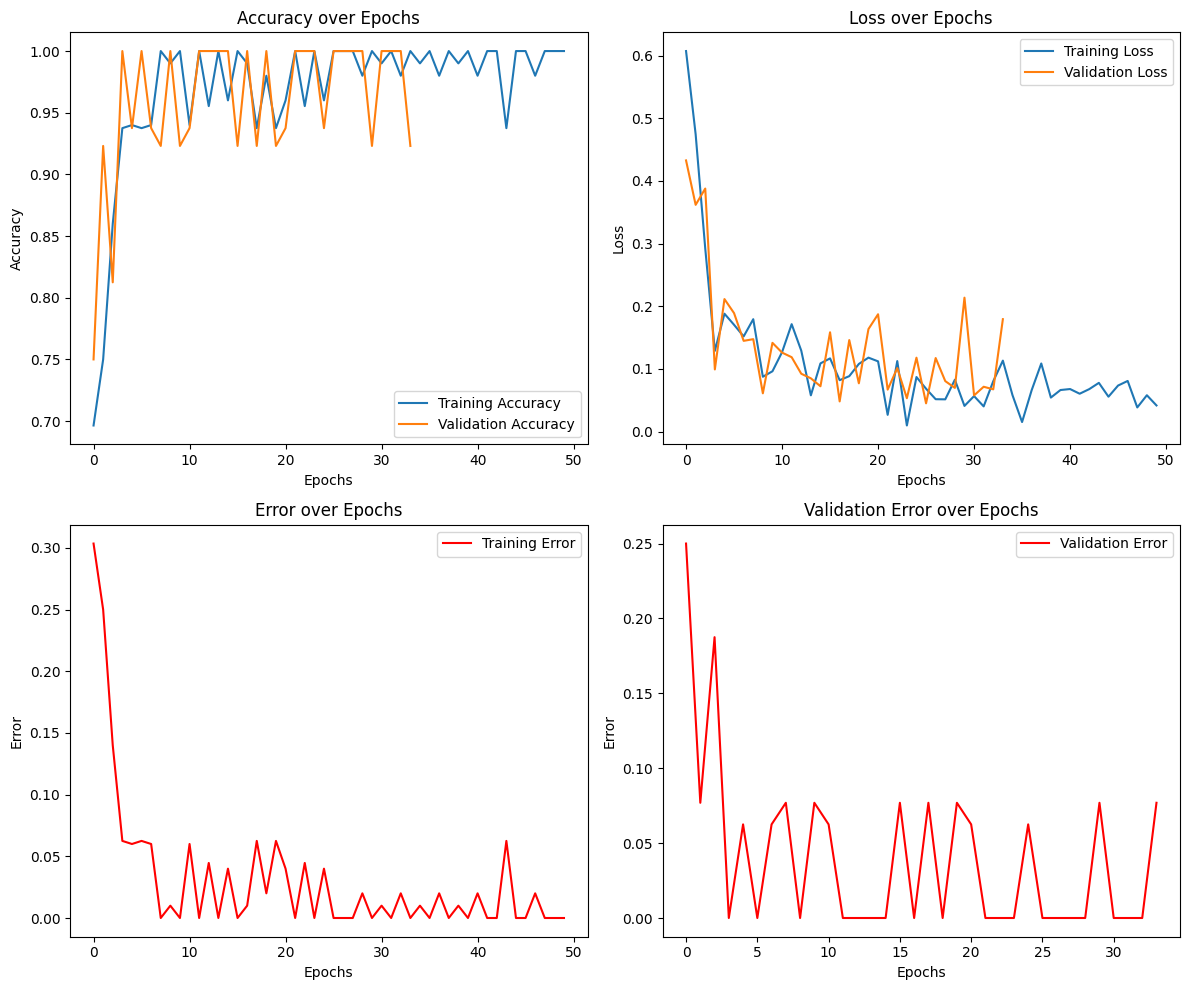

Found 145 images belonging to 2 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 1.0000 - loss: 0.0363
Test Accuracy: 1.00
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step


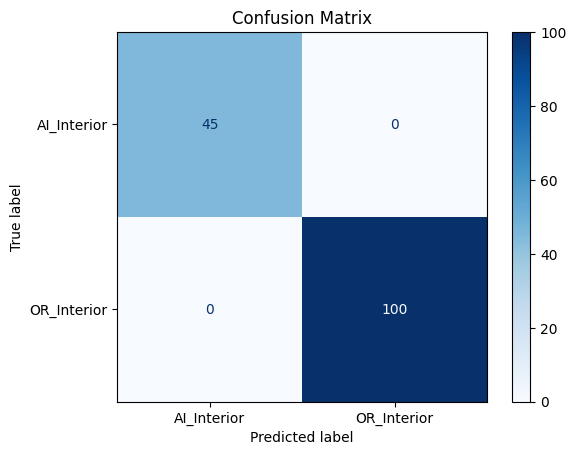

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load pre-trained MobileNet without the top layers (for transfer learning)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model
base_model.trainable = False

# Build the custom model on top of MobileNet
model = models.Sequential([
    base_model,  # Adding pre-trained MobileNet as base
    layers.GlobalAveragePooling2D(),  # Global Average Pooling
    layers.Dense(128, activation='relu'),  # Dense layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- Data Augmentation and Preprocessing ---
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split for validation
)

train_generator = datagen.flow_from_directory(
    '/content/images',
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/content/images',
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary',
    subset='validation'
)

# --- Callbacks ---
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(-epoch / 20))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# --- Train the Model ---
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping, model_checkpoint, lr_schedule]
)

# --- Log Accuracy and Error ---
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Calculate Error
train_error = [1 - acc for acc in train_accuracy]
val_error = [1 - acc for acc in val_accuracy]

# --- Plot Logs ---
def plot_logs(train_accuracy, val_accuracy, train_error, val_error, train_loss, val_loss):
    plt.figure(figsize=(12, 10))

    # Accuracy plot
    plt.subplot(2, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    # Loss plot
    plt.subplot(2, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Train error plot
    plt.subplot(2, 2, 3)
    plt.plot(train_error, label='Training Error', color='r')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Error over Epochs')
    plt.legend()

    # Validation error plot
    plt.subplot(2, 2, 4)
    plt.plot(val_error, label='Validation Error', color='r')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Validation Error over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_logs(train_accuracy, val_accuracy, train_error, val_error, train_loss, val_loss)

# --- Evaluate the Model ---
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/images',
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

# --- Confusion Matrix ---
def plot_confusion_matrix(model, generator):
    predictions = (model.predict(generator) > 0.5).astype(int)
    y_true = generator.classes
    cm = confusion_matrix(y_true, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=generator.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, test_generator)


In [15]:
# prompt: generate architecture of following model, # Define the CNN model architecture
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load pre-trained MobileNet without the top layers (for transfer learning)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model
base_model.trainable = False

# Build the custom model on top of MobileNet
model = models.Sequential([
    base_model,  # Adding pre-trained MobileNet as base
    layers.GlobalAveragePooling2D(),  # Global Average Pooling
    layers.Dense(128, activation='relu'),  # Dense layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

from tensorflow.keras.utils import plot_model

# Assuming 'model' is defined as in your previous code
# ... your model definition ...


plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
model.summary()

<ipython-input-15-263337809278>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 8, 8, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,360,193 (12.82 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [16]:
!pip install pillow


In [17]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 18.3 MB/s eta 0:00:00


<ipython-input-19-72a5d1285b4d>:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


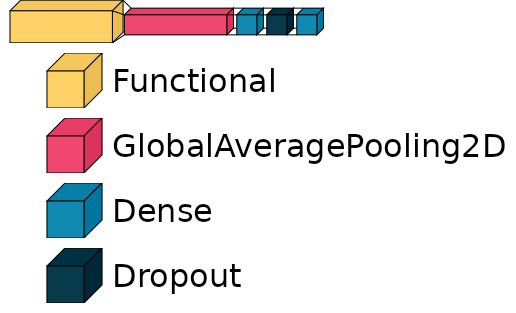

In [19]:
# Install visualkeras
!pip install visualkeras

import visualkeras
from PIL import ImageFont
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models

# Load pre-trained MobileNet model without the top layers (for transfer learning)
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model
base_model.trainable = False

# Build the custom model on top of MobileNet
model = models.Sequential([
    base_model,  # Adding pre-trained MobileNet as base
    layers.GlobalAveragePooling2D(),  # Global Average Pooling
    layers.Dense(128, activation='relu'),  # Dense layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

# Use a system-installed font like DejaVu Sans
font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 32)

# Visualize the model
visualkeras.layered_view(model, legend=True, font=font)


In [20]:

import tensorflow as tf
from tensorflow.keras import layers, models, Input
import visualkeras
from PIL import ImageFont
import matplotlib.pyplot as plt


# Use a system-installed font
font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 32)

# Define the text_callable function to annotate layers with output shapes and names
def text_callable(layer_index, layer):
    # Every other piece of text is drawn above the layer, the first one below
    above = bool(layer_index % 2)

    # Get the output shape of the layer using layer.output.shape
    output_shape = [x for x in list(layer.output.shape) if x is not None]

    # If the output shape is a list of tuples, we only take the first one
    if isinstance(output_shape[0], tuple):
        output_shape = list(output_shape[0])
        output_shape = [x for x in output_shape if x is not None]

    # Variable to store text which will be drawn
    output_shape_txt = ""

    # Create a string representation of the output shape
    for ii in range(len(output_shape)):
        output_shape_txt += str(output_shape[ii])
        if ii < len(output_shape) - 2:  # Add an x between dimensions, e.g. 3x3
            output_shape_txt += "x"
        if ii == len(output_shape) - 2:  # Add a newline between the last two dimensions, e.g. 3x3 \n 64
            output_shape_txt += "\n"

    # Add the name of the layer to the text, as a new line
    output_shape_txt += f"\n{layer.name}"

    # Return the text value and if it should be drawn above the layer
    return output_shape_txt, above

# Create the model plot
fig = plt.figure(figsize=(12, 8))  # Adjust this to increase the width

# Visualize the model with the text_callable function
visualkeras.layered_view(model, legend=True, font=font, text_callable=text_callable)

# Save or show the plot
plt.savefig("/content/model_architecture_with_text.png", dpi=300)  # Adjust DPI to improve quality
plt.show()


<Figure size 1200x800 with 0 Axes>

**END**